# 依美國冠軍 Mark Minervini的策略

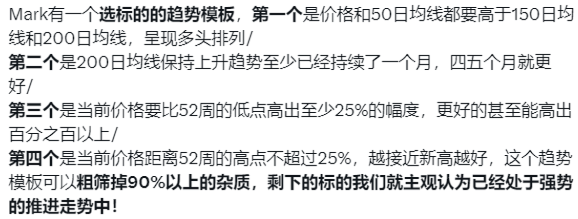

In [66]:
import pymysql
import numpy as np
import pandas as pd
import time,os,ccxt
from datetime import datetime,timedelta
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# import talib as ta
from talib import abstract as ab

# pd.options.display.float_format = '{:.2f}'.format
# pd.options.mode.chained_assignment = None  # default='warn'

def read_from_mysql(tablename):
    conn = pymysql.connect(host='192.168.68.122',user='testuser',passwd='test1234',db='testuser',charset='utf8')


    sql="select * from "
    sql=sql +tablename 
    

    df= pd.read_sql(sql, conn)
    conn.close()

    return df

def RSI_up_cross(df):
    if df.pre_RSI_rank==0 and df.RSI_rank==1 :
        return 1
    elif df.pre_RSI_rank==1 and df.RSI_rank==0 :
        return -1
    else:
        return 0


    

def handle_data(df,fast,slow,factor_out):
    # 把string改成float，以利後續計算：
    df['open']=df['price_open'].astype(float)
    df['high']=df['price_high'].astype(float)
    df['low']=df['price_low'].astype(float)
    df['close']=df['price_close'].astype(float)
    df['volume']=df['volume'].astype(float)

    #---------集中drop 區-----------------------------------------------------
    df['EMA_fast'] = ab.EMA(df,timeperiod=fast)
    df['EMA_slow'] = ab.EMA(df,timeperiod=slow)
    df['EMA_200'] = ab.EMA(df,timeperiod=200)
    # df.dropna(inplace=True) #集中
    df['W52_LL']=df['close'].rolling(365).min()
    # df.dropna(inplace=True) #集中
    df['W52_HH']=df['close'].rolling(365).max()
    # df.dropna(inplace=True) #集中

    df['ATR'] = ab.ATR(df,timeperiod=fast)
    df['HH']=df['close'].rolling(fast).max()
    df.dropna(inplace=True) #集中









    #---------condition1 --------------------------------------------------------------
    # df['EMA_fast'] = ab.EMA(df,timeperiod=fast)
    # df['EMA_slow'] = ab.EMA(df,timeperiod=slow)
    # df['EMA_200'] = ab.EMA(df,timeperiod=200)
    # df.dropna(inplace=True) #集中
    
    df['EMA_rank-1']=(df['close']-df['EMA_slow']).apply(lambda x:1 if x>0 else 0) #價格>150日
    df['EMA_rank-2']=(df['close']-df['EMA_200']).apply(lambda x:1 if x>0 else 0) #價格>200日
    df['EMA_rank-3']=(df['EMA_fast']-df['EMA_slow']).apply(lambda x:1 if x>0 else 0) #MA50>150日
    df['EMA_rank-4']=(df['EMA_fast']-df['EMA_200']).apply(lambda x:1 if x>0 else 0) #MA50>200日
 
    # df['EMA_rank']=(df['EMA_rank-1']+df['EMA_rank-2']+df['EMA_rank-3']+df['EMA_rank-4']).apply(lambda x:1 if x==4 else 0)  #以上4項都要符合
    df['EMA_rank']=(df['EMA_rank-1']+df['EMA_rank-2']).apply(lambda x:1 if x==2 else 0)  
    
    
    
    #---------condition2 --------------------------------------------------------------
    df['200_rank']=(df['close']-df['EMA_200']).apply(lambda x:1 if x>0 else 0)
    df['bull_cnt']=df['200_rank'].rolling(30).agg(lambda x: (x>0).sum())
    df.dropna(inplace=True) 
    df['bull_cnt_rank']=df['bull_cnt'].apply(lambda x:1 if x>=30 else 0) #連續30天都在MA200之上



    
    #---------condition3: --------------------------------------------------------------
    # df['W52_LL']=df['close'].rolling(365).min()
    # df.dropna(inplace=True) #集中

    df['W52_LL_rank']=(df['close']/df['W52_LL']).apply(lambda x:1 if x>1.25 else 0) #目前價格大於52周低點至少25%(最好是100%)



    #---------condition4: --------------------------------------------------------------
    # df['W52_HH']=df['close'].rolling(365).max()
    # df.dropna(inplace=True) #集中

    df['W52_HH_rank']=(df['close']/df['W52_HH']).apply(lambda x:1 if x>0.75 else 0) #目前價格距離52周高點不超過25%(愈接近新高愈好)





    #---------Chandelier------------------------------
    # df['ATR'] = ab.ATR(df,timeperiod=fast)
    # df['HH']=df['close'].rolling(fast).max()
    # df.dropna(inplace=True) #集中

    df['Chand_stop']=(df['close']-(df['HH']-factor_out*df['ATR'])).apply(lambda x:1 if x>0 else 0) #1 表示收盤價在吊燈上方，繼續持有
    # df['Chandelier_bull_rank_exit']=(df['close']-(df['HH']-0.9*factor_out*df['ATR'])).apply(lambda x:1 if x>0 else 0) #ATR*0.9-->早點離場




    #定義進出訊號：
    df['entries']=(df['EMA_rank']+df['bull_cnt_rank']+df['W52_LL_rank']+df['W52_HH_rank']+df['Chand_stop']).apply(lambda x:1 if x>=5  else 0) 
    # df['entries']=(df['EMA_rank']+df['bull_cnt_rank']+df['W52_LL_rank']+df['W52_HH_rank']).apply(lambda x:1 if x==4  else 0) 
    df['exits']=(df['Chand_stop']).apply(lambda x:1 if x==0 else 0) 

    


    #砍掉多餘的：
    # df.drop(columns=['human_time','open_time'],inplace=True) #把時間刪掉了
    df.dropna(inplace=True)
    # df=df.reset_index()



    return df


In [57]:
df=handle_data(df_raw,50,150,2)
df['entries'].value_counts()

0    47185
1     3225
Name: entries, dtype: int64

In [58]:
df['exits'].value_counts()

1    28837
0    21573
Name: exits, dtype: int64

In [59]:
df['Chand_stop'].value_counts()

0    28837
1    21573
Name: Chand_stop, dtype: int64

# 回測：

In [71]:
#讀取資料：
symbol='FTM/USDT'
df_raw=read_from_mysql(symbol.replace('/','_')+"_1h")
# print(len(df_raw))
df=df_raw.copy()
# df=df.iloc[-99999:-9999,:] #all(train+Test), for best
df=df.iloc[-33333:,:] #for 普適性33
########## parameters #######################

fast=5
slow=93
factor_out=2.8

############## handle_data ##############################
df=handle_data(df,fast,slow,factor_out)
# df.head()

import vectorbt as vbt #看來都要塞array進去當參數，用 df.values

entries=df.apply(lambda x: (x['entries']==1),axis=1)
exits=df.apply(lambda x: (x['exits']==1),axis=1)
# print(entries.value_counts(),'___',exits.value_counts()) #計算true/false個數
pf=vbt.Portfolio.from_signals(df['close'].values,entries=entries,exits=exits,init_cash=100,fees=0.0004) 
print(pf.stats())

Start                         9154.00
End                          42093.00
Period                       32940.00
Start Value                    100.00
End Value                    34992.22
Total Return [%]             34892.22
Benchmark Return [%]         15961.59
Max Gross Exposure [%]         100.00
Total Fees Paid                206.83
Max Drawdown [%]                89.08
Max Drawdown Duration         9419.00
Total Trades                    47.00
Total Closed Trades             46.00
Total Open Trades                1.00
Open Trade PnL               21070.98
Win Rate [%]                    45.65
Best Trade [%]                1877.98
Worst Trade [%]                -52.25
Avg Winning Trade [%]          131.85
Avg Losing Trade [%]           -12.31
Avg Winning Trade Duration     536.33
Avg Losing Trade Duration      151.92
Profit Factor                    1.83
Expectancy                     300.46
dtype: float64


In [72]:
#draw chart:
pf.orders.plot(width=1500)

FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'f64e725f-ae16-4dd8-b195-b657c2814073',
              'x': array([ 9154,  9155,  9156, ..., 42091, 42092, 42093], dtype=int64),
              'y': array([0.00617, 0.00617, 0.0063 , ..., 0.998  , 0.9961 , 0.991  ])},
             {'customdata': array([[0.00000000e+00, 8.87744369e+03, 3.99840064e-02],
                                   [2.00000000e+00, 7.02866988e+03, 4.27905422e-02],
                                   [4.00000000e+00, 6.53101097e+03, 1.03660206e-01],
                                   [6.00000000e+00, 6.65240502e+03, 8.64014364e-02],
                                   [8.00000000e+00, 9.74928362e+03, 7.67073635e-02],
                                   [1.00000000e+01, 9.46688256e+03, 7.92567408e-02],
                                   [1.20000000e+01, 9.25933645e+03, 7.53339614e-02],
           

# GA

In [68]:
#GA combine test:
strategy='mark-1'
symbols=['ADA/USDT','BCH/USDT','DOGE/USDT','DOT/USDT','FTM/USDT','LINK/USDT','LTC/USDT','MATIC/USDT','SOL/USDT','TRX/USDT','XRP/USDT','BTC/USDT','ETH/USDT']
# symbols=['TRX/USDT']

for symbol in symbols:


    df_raw=read_from_mysql(symbol.replace('/','_')+"_1h")
    print(f'{symbol} data length: {len(df_raw)}')

    def train_GA(x,y,z):
        #讀取資料：
        # symbol='DOGE/USDT'
        # df=read_from_mysql(symbol.replace('/','_')+"_15m")
        df=df_raw.copy()
        # df=df.iloc[-99999:-9999,:] #留下-9999當測試普適性用的
        df=df.iloc[-33333:,:] #這幾個交易對都是適合的，直接用最近的33333筆資料算最佳參數
        
        
        ########## parameters #######################

        fast=x
        slow=y  #factor_in: 1.2~4.4 (2^5) 
        factor_out=z/10 #factor_out: 5~37 (2^5)

        ############## handle_data ##############################
        df=handle_data(df,fast,slow,factor_out)

        
        ############
        import vectorbt as vbt #看來都要塞array進去當參數，用 df.values
        entries=df.apply(lambda x: (x['entries']==1),axis=1)
        exits=df.apply(lambda x: (x['exits']==1),axis=1)


        pf=vbt.Portfolio.from_signals(df['close'].values,entries=entries,exits=exits,init_cash=100,fees=0.0004) 
        result=pf.stats()['Total Return [%]']
        # result=pf.stats()['Win Rate [%]'] #改用勝率來看這種方法好不好，用total return怕over fitting
        # result=pf.stats()['Avg Winning Trade [%]'] + pf.stats()['Avg Losing Trade [%]']*2
      

        # if pf.stats()['Total Return [%]']> pf.stats()['Benchmark Return [%]'] :
        if  pf.stats()['Total Return [%]']> (pf.stats()['Benchmark Return [%]']*1.2 ) and \
            pf.stats()['Profit Factor']>1.2  and \
            pf.stats()['Total Trades']>33 and  \
            (pf.stats()['Avg Winning Trade [%]'] + pf.stats()['Avg Losing Trade [%]']*2 )>0.6: # and \
            # pf.stats()['Win Rate [%]']>33 and  \
            # pf.stats()['Max Drawdown [%]']<33 : 
          

            return result
        else:
            return 0.01
        



    # if not (np.isnan(prob[j])):
    #     outputText += np.random.choice(data, p=prob)

        
        
        
    def F(pop):
        
        
        
        scores=[]
        for k in range(len(pop)):
            
            #將DNA拆成3個值
            #res = int("".join(str(x) for x in pop[0][0:3]), 2)
            x=int("".join(str(x) for x in pop[k][0:5]), 2)+5 #5~37
            y=int("".join(str(x) for x in pop[k][5:11]), 2)+39 #39~103 
            z=int("".join(str(x) for x in pop[k][11:16]), 2)+11 #11~43    (/10)     


    #         if (long_period>middle_period and middle_period>short_period): #舊的寫法要判斷長天期MA要> 小天期MA
            if 1==1:
                
                score=train_GA(x,y,z)
                scores.append(score)

                
            
            else:
    #             print('xxxxxxxxxxxxxxxxxxx  wrong number setup  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
                score=0.1
                scores.append(score)
                continue
            
    
            
            
        return np.array(scores)


    # GA testing:

    # import numpy as np
    # import matplotlib.pyplot as plt

    DNA_SIZE = 16            # DNA length (上面parameters的總合)
    POP_SIZE = 999           # population size
    CROSS_RATE = 0.9         # mating probability (DNA crossover)
    MUTATION_RATE = 0.009    # mutation probability
    N_GENERATIONS = 1
    X_BOUND = [3,39]         # x upper and lower bounds (這個沒用到了！)


    # def F(x): return np.sin(10*x)*x + np.cos(2*x)*x     # to find the maximum of this function


    # find non-zero fitness for selection
    def get_fitness(pred): return pred + 1e-3 - np.min(pred) 


    # convert binary DNA to decimal and normalize it to a range(0, 5)
    def translateDNA(pop): 
    #     return pop.dot(2 ** np.arange(DNA_SIZE)[::-1]) / float(2**DNA_SIZE-1) * X_BOUND[1]
        return (pop.dot(2 ** np.arange(DNA_SIZE)[::-1]) / (2**DNA_SIZE-1) * X_BOUND[1]).astype(int)+X_BOUND[0]




    def select(pop, fitness):    # nature selection wrt pop's fitness
        idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True,
                            p=fitness/fitness.sum())
        return pop[idx]


    def crossover(parent, pop):     # mating process (genes crossover)
        if np.random.rand() < CROSS_RATE:
            i_ = np.random.randint(0, POP_SIZE, size=1)                             # select another individual from pop
            cross_points = np.random.randint(0, 2, size=DNA_SIZE).astype(np.bool)   # choose crossover points
            parent[cross_points] = pop[i_, cross_points]                            # mating and produce one child
        return parent


    def mutate(child):
        for point in range(DNA_SIZE):
            if np.random.rand() < MUTATION_RATE:
                child[point] = 1 if child[point] == 0 else 0
        return child


    pop = np.random.randint(2, size=(POP_SIZE, DNA_SIZE))   # initialize the pop DNA

    # plt.ion()       # something about plotting
    # x = np.linspace(*X_BOUND, 200)
    # plt.plot(x, F(x))


    for iii in range(N_GENERATIONS):
        F_values = F(pop)    # compute function value by extracting DNA

        # something about plotting
    #     if 'sca' in globals(): sca.remove()
    #     sca = plt.scatter(translateDNA(pop), F_values, s=200, lw=0, c='red', alpha=0.5); plt.pause(0.05)

        # GA part (evolution)
        fitness = get_fitness(F_values)
        x_result=int("".join(str(x) for x in pop[np.argmax(fitness)][0:5]), 2)+5
        y_result=int("".join(str(x) for x in pop[np.argmax(fitness)][5:11]), 2)+39
        z_result=round((int("".join(str(x) for x in pop[np.argmax(fitness)][11:16]), 2)+11)/10,1)
        final_result=np.max(F_values)

        print(f'G{iii} --Most fitted DNA:  {pop[np.argmax(fitness)]} --> {x_result},{y_result},{z_result}---> {final_result}')
        


        #2023/11/30 add 寫入結果到GA.csv :
        df=pd.read_csv('GA-19.csv')
        mydate=datetime.now().strftime("%Y%m%d")
        df.loc[len(df.index)]=[mydate,strategy,symbol,x_result,y_result,z_result,final_result]
        # df.iloc[-1,0]=strategy
        # df.iloc[-1,1]=symbol
        # df.iloc[-1,2]= x_result
        # df.iloc[-1,3]= y_result
        # df.iloc[-1,4]= z_result
        # df.iloc[-1,5]= final_result

        df.to_csv('GA-19.csv',index=False)



        # 2022/09/10 增加突變率變化：(開始時突變率高)
        if iii<3:
            MUTATION_RATE = 0.09
        else:
            MUTATION_RATE = 0.003
            
        
        
        pop = select(pop, fitness)
        pop_copy = pop.copy()
        for parent in pop:
            child = crossover(parent, pop_copy)
            child = mutate(child)
            parent[:] = child       # parent is replaced by its child
        
    

ADA/USDT data length: 52130
G0 --Most fitted DNA:  [0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 1] --> 15,58,4.0---> 0.01
BCH/USDT data length: 38020
G0 --Most fitted DNA:  [1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0] --> 32,77,3.5---> 0.01
DOGE/USDT data length: 41510
G0 --Most fitted DNA:  [0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1] --> 5,54,3.8---> 0.01
DOT/USDT data length: 31683
G0 --Most fitted DNA:  [0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1] --> 6,91,2.6---> 499.36499621650444
FTM/USDT data length: 42094
G0 --Most fitted DNA:  [0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1] --> 5,93,2.8---> 34892.223080091084
LINK/USDT data length: 45576
G0 --Most fitted DNA:  [1 1 0 1 0 0 0 1 1 0 1 1 0 0 0 1] --> 31,52,2.8---> 0.01
LTC/USDT data length: 55097
G0 --Most fitted DNA:  [0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0] --> 11,101,4.1---> 0.01
MATIC/USDT data length: 43177
G0 --Most fitted DNA:  [1 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1] --> 21,60,3.2---> 0.01
SOL/USDT data length: 31868
G0 --Most fitted DNA:  [0 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1] --> 8,74,3.8---> 7902

In [73]:
df=pd.read_csv('GA-19.csv')
df.head()

,date,strategy,symbol,x,y,z,result
0,20240415,mark-1,ADA/USDT,13,6.90,2.30,0.01
1,20240415,mark-1,ADA/USDT,15,2.20,2.90,0.01
2,20240415,mark-1,ADA/USDT,15,58.00,4.00,0.01
3,20240415,mark-1,BCH/USDT,32,77.00,3.50,0.01
4,20240415,mark-1,DOGE/USDT,5,54.00,3.80,0.01


In [75]:
symbols=['FTM/USDT','SOL/USDT','DOT/USDT'] #BTC 有開單最小量限制，較不好拿來測 , shib好像有乘以1000先捨棄

for symbol in symbols:

    #--------------------------------------  general parameters -------------------------------------- 
    budget=9
    current_time=datetime.now().strftime("%Y/%m/%d_%H")
    strategy='mark-1' 
    leverage=9

    

    #--------------------------------------  indivisual parameters --------------------------------------
    #2023/12/13新增改自動每周update GA parameters: (用這個就不用if條件式一個一個key了)
    df_para=pd.read_csv('./GA-19.csv')
    mask=(df_para['strategy']==strategy) & (df_para['symbol']==symbol) & (df_para['result']!=0.01)  

    fast=df_para[mask]['x'].iloc[-1]
    slow=df_para[mask]['y'].iloc[-1]
    factor_out=df_para[mask]['z'].iloc[-1] #2023/12/14改成由csv file除以10了，這裡直接調用不用再除

    print(f'-------{symbol}:fast={fast},slow={slow},factor_out={factor_out}---------')

-------FTM/USDT:fast=5,slow=93.0,factor_out=2.8---------
-------SOL/USDT:fast=8,slow=74.0,factor_out=3.8---------
-------DOT/USDT:fast=6,slow=91.0,factor_out=2.6---------


In [81]:
df_para=pd.read_csv('GA-19.csv')
mask=(df_para['strategy']==strategy) & (df_para['symbol']==symbol) & (df_para['result']!=0.01)  

fast=int(df_para[mask]['x'].iloc[-1])
slow=df_para[mask]['y'].iloc[-1]
factor_out=df_para[mask]['z'].iloc[-1] #2023/12/14改成由csv file除以10了，這裡直接調用不用再除

print(f'-------{symbol}:fast={fast},slow={slow},factor_out={factor_out}---------')

-------DOT/USDT:fast=6,slow=91.0,factor_out=2.6---------


In [82]:
type(fast)

int